# Advanced Example
In this interactive example we illustrate the interactivity of _PHRINGE_. We will show how to generate a synthetic data set using manually created ``Observation``, ``Instrument`` and ``Scene`` objects, whose attributes we are going to update along the way and directly see the impact on the generated data.

### Import the Required Modules


In [4]:
import astropy.units as u
import matplotlib.pyplot as plt

from phringe.core.instrument import Instrument
from phringe.core.observation import Observation
from phringe.core.perturbations.power_law_psd_perturbation import PowerLawPSDPerturbation
from phringe.core.scene import Scene
from phringe.core.sources.exozodi import Exozodi
from phringe.core.sources.local_zodi import LocalZodi
from phringe.core.sources.planet import Planet
from phringe.core.sources.star import Star
from phringe.lib.array_configuration import XArrayConfiguration
from phringe.lib.beam_combiner import DoubleBracewell
from phringe.main import PHRINGE
from phringe.util.baseline import OptimalNullingBaseline

### Setup PHRINGE

**Create the Main PHRINGE Object**

_PHRINGE_ is optimized to run on GPUs, but can also be run on CPUs. Setting `gpu_index=None` will result in CPU usage only, while specifying e.g. `gpu_index=0` will use the zeroth available GPU. For reproducibility, `seed` can be set to a specific value, resulting in identical results for each run. Note that `seed=None` results in the use of a random seed each run. The `grid_size` parameter specifies the number of grid points in the spatial domain. The larger the grid size, the more accurate the results, but the longer the computation time.

In [ ]:
phringe = PHRINGE(gpu_index=1, seed=42, grid_size=60)

**Create and Set an Observation**

Arguments that require numerical values with units can be passed either as 
1. astropy quantities, e.g. `10 * u.m`
2. strings with units, e.g. `'10 m'`, or
3. floats (ints), assuming SI units, e.g. `10`.

The use of astropy quantities is recommended for clarity.

In [5]:
obs = Observation(
    solar_ecliptic_latitude=0 * u.deg,  # Alternatively: '0 deg' or 0
    total_integration_time=1 * u.day,  # Alternatively: '1 d' or 86400
    detector_integration_time=600 * u.s,  # Alternatively: '600 s' or 600
    modulation_period=1 * u.day,  # Alternatively: '1 d' or 86400
    nulling_baseline=OptimalNullingBaseline(  # Alternatively a fixed value, e.g. 10 * u.m
        angular_star_separation=0.1 * u.arcsec,
        wavelength=10 * u.um,
        sep_at_max_mod_eff=DoubleBracewell.sep_at_max_mod_eff[0]
    ),
)
phringe.set(obs)

**Note:** After initialization, the class attributes are converted to SI units and stored as floats, as astropy quantiteis can have a significant impact on performance. Consider, for instance, the total integration time, which has been converted to a float in seconds:

In [6]:
obs.total_integration_time

86400.0

**Create and Set an Instrument**

An instrument can be created manually using the `Instrument` class ([see here for the class documentation](../source/instrument.rst)) or by using a predefined instrument from the library. Here, we use the predefined LIFE baseline architecture as our instrument.   

In [7]:
inst = Instrument(
    array_configuration_matrix=XArrayConfiguration.acm,
    complex_amplitude_transfer_matrix=DoubleBracewell.catm,
    kernels=DoubleBracewell.kernels,
    aperture_diameter=3 * u.m,
    nulling_baseline_min=8 * u.m,
    nulling_baseline_max=100 * u.m,
    throughput=0.12,
    quantum_efficiency=0.7,
    spectral_resolving_power=20,
    wavelength_min=4 * u.um,
    wavelength_max=18.5 * u.um,
    wavelength_bands_boundaries=[],  # Alternatively e.g. ['9 um']
    amplitude_perturbation=PowerLawPSDPerturbation(coefficient=1, rms=0.1 * u.percent),
    phase_perturbation=PowerLawPSDPerturbation(coefficient=1, rms=1.5 * u.nm, chromatic=True),
    polarization_perturbation=PowerLawPSDPerturbation(coefficient=1, rms=0.001 * u.rad)
)
phringe.set(inst)

**Note:** Attributes of objects can also be updated. For instance, changing the aperture diameter from the predefined value to 3.5 m:

In [8]:
print(f'Predefined aperture diameter: {inst.aperture_diameter}')

inst.aperture_diameter = 3.5  # Attributes are stored as floats (see above), so we input floats in SI units

print(f'Updated aperture diameter: {inst.aperture_diameter}')

Predefined aperture diameter: 3.0
Updated aperture diameter: 3.5


For the instrument we have defined we can now e.g. check the resulting wavelength bins. This depends on its minimum and maximum wavelengths and spectral resolving power:

In [9]:
phringe.get_wavelength_bin_centers()
phringe.get_wavelength_bin_centers().cpu().numpy()  # as a numpy array

array([4.10256416e-06, 4.31295211e-06, 4.53412895e-06, 4.76664854e-06,
       5.01109207e-06, 5.26807116e-06, 5.53822838e-06, 5.82224038e-06,
       6.12081658e-06, 6.43470457e-06, 6.76468972e-06, 7.11159691e-06,
       7.47629383e-06, 7.85969405e-06, 8.26275482e-06, 8.68648567e-06,
       9.13194708e-06, 9.60025136e-06, 1.00925727e-05, 1.06101397e-05,
       1.11542495e-05, 1.17262625e-05, 1.23276095e-05, 1.29597947e-05,
       1.36243998e-05, 1.43230864e-05, 1.50576043e-05, 1.58297880e-05,
       1.66415721e-05], dtype=float32)

**Create and Set a Scene**

The `Scene` object defined the astrophysical scene that is observed by the instrument. We first create an empty scene and then add sources to it; here, a star with an exozodiacal disk (exozodi) orbited by a planet as seen through the local zodiacal dust (local zodi).

In [10]:
scene = Scene()
phringe.set(scene)

sun_twin = Star(
    name='Sun-Twin',
    distance=10 * u.pc,
    mass=1 * u.Msun,
    radius=1 * u.Rsun,
    temperature=5778 * u.K,
    right_ascension=10 * u.hourangle,  # Uses units of degrees, not time
    declination=45 * u.deg,
)
earth_twin = Planet(
    name='Earth-Twin',
    has_orbital_motion=False,  # Whether the planet is propagated in time along its orbit
    mass=1 * u.Mearth,
    radius=1 * u.Rearth,
    temperature=254 * u.K,
    semi_major_axis=1 * u.au,
    eccentricity=0,
    inclination=0 * u.deg,
    raan=0 * u.deg,
    argument_of_periapsis=135 * u.deg,
    true_anomaly=0 * u.deg,
    input_spectrum=None,
    # host_star_distance=10 * u.pc,  # Is only required if no star is added explicitly to the scene
    # host_star_mass=1 * u.Msun,  # Is only required if no star is added explicitly to the scene
)
exozodi = Exozodi(
    level=3.0,  # 3 times the local zodiacal dust level
    # host_star_luminosity=1 * u.Lsun,  # Is only required if no star is added explicitly to the scene
    # host_star_distance=10 * u.pc,  # Is only required if no star is added explicitly to the scene
)
local_zodi = LocalZodi(
    # host_star_right_ascension=10 * u.hourangle,  # Is only required if no star is added explicitly to the scene
    # host_star_declination=45 * u.deg,  # Is only required if no star is added explicitly to the scene
)

scene.add_source(sun_twin)
scene.add_source(earth_twin)
scene.add_source(exozodi)
scene.add_source(local_zodi)

We can now also have a look at the spectra that have been generated for the sources:

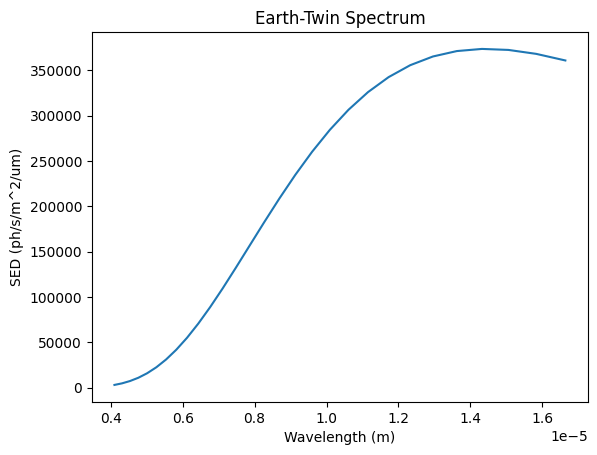

In [11]:
earth_twin_spectrum = phringe.get_source_spectrum('Earth-Twin').cpu().numpy()
wavelengths = phringe.get_wavelength_bin_centers().cpu().numpy()

plt.title('Earth-Twin Spectrum')
plt.plot(wavelengths, earth_twin_spectrum)
plt.ylabel('SED (ph/s/m^2/um)')
plt.xlabel('Wavelength (m)')
plt.show()

Once we have set an observation, an instrument and the star, we can also calculate the resulting nulling baseline length in meters (SI units):

In [12]:
phringe.get_nulling_baseline()

12.375888374825779

### Run PHRINGE

**Calculate the Counts on the Detector**

We calculate the raw counts at all four outputs of the nulling interferometer and use it to calculate the differential counts (on a CPU this is likely going to take a few tens of seconds).

In [13]:
counts = phringe.get_counts(kernels=True)

**Plot the Differential Counts**

Then we can plot the differential counts:

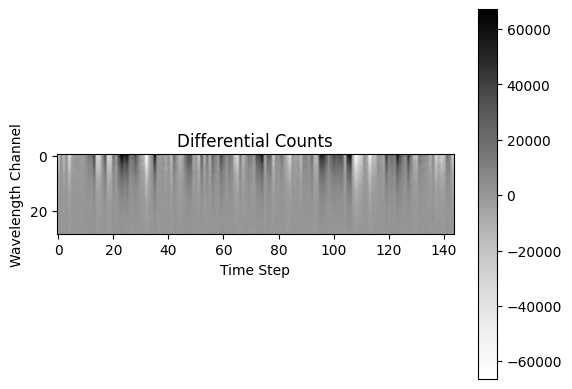

In [14]:
plt.imshow(counts.cpu().numpy()[0], cmap='Greys')
plt.title('Differential Counts')
plt.ylabel('Wavelength Channel')
plt.xlabel('Time Step')
plt.colorbar()
plt.show()

We now remove the instrument perturbations, increase the planet radius and reduce the radius of the star to see what impact this has on the data. 

In [15]:
inst.amplitude_perturbation = None
inst.phase_perturbation = None
inst.polarization_perturbation = None
earth_twin.radius *= 2
sun_twin.radius /= 2

counts = phringe.get_counts(kernels=True)

As we can see, this not only reduces the counts on our detector, but also makes the planet signal appear. One could almost mistake this for the fur of a zebra...

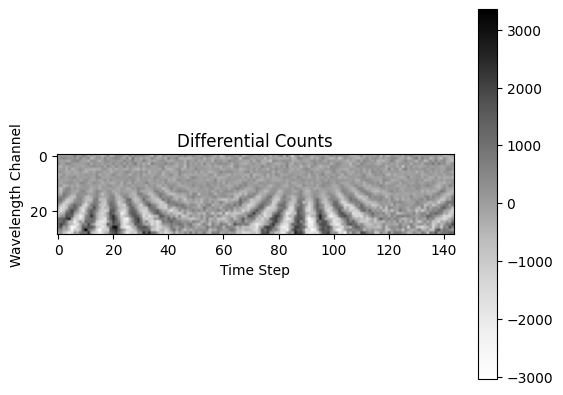

In [16]:
plt.imshow(counts.cpu().numpy()[0], cmap='Greys')
plt.title('Differential Counts')
plt.ylabel('Wavelength Channel')
plt.xlabel('Time Step')
plt.colorbar()
plt.show()

Compared to this, we can also have a look what the theoretical planet signal (template/model) would look like with a given spectrum and position:

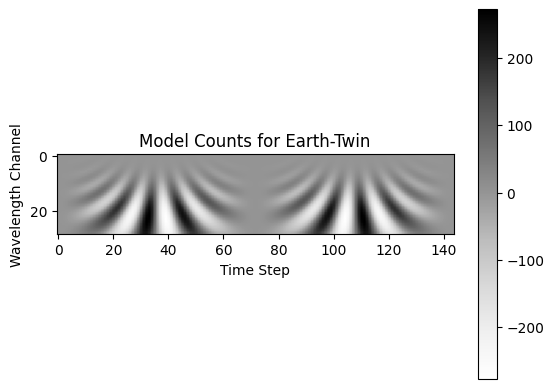

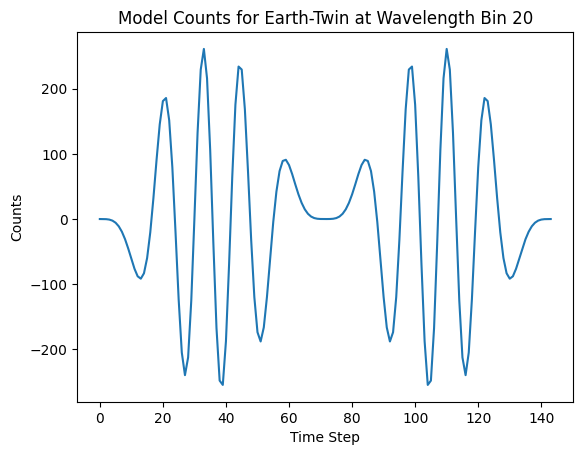

In [17]:
model_counts = phringe.get_model_counts(
    kernels=True,
    spectral_energy_distribution=earth_twin_spectrum,
    x_position=3e-7,  # in radians
    y_position=0e-7  # in radians
)

plt.imshow(model_counts[0], cmap='Greys')
plt.title('Model Counts for Earth-Twin')
plt.ylabel('Wavelength Channel')
plt.xlabel('Time Step')
plt.colorbar()
plt.show()

# Or at one wavelength
plt.plot(model_counts[0, 20])
plt.title('Model Counts for Earth-Twin at Wavelength Bin 20')
plt.ylabel('Counts')
plt.xlabel('Time Step')
plt.show()

**Plot Instrument Response**

We can also have a look at the instrument response of our setup. To increase the resolution of this map increase the `grid_size` parameter when creating the `PHRINGE` object above.

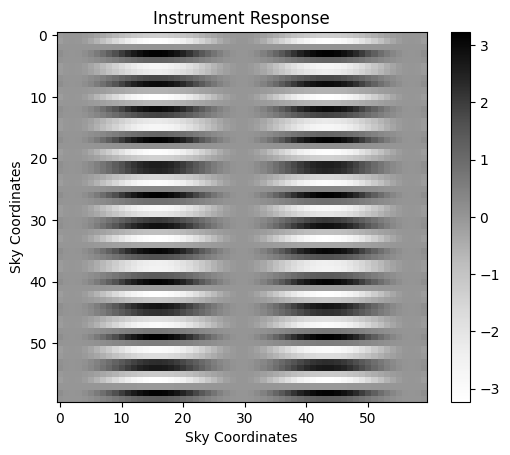

In [18]:
fov_max = phringe.get_field_of_view()[0].item()
ir = phringe.get_instrument_response(fov=fov_max, kernels=True, perturbations=True)

# Get response at 10th wavelength bin and zeroth time step
ir = ir[:, 10, 0]

plt.imshow(ir.cpu().numpy()[0], cmap='Greys')
plt.title('Instrument Response')
plt.ylabel('Sky Coordinates')
plt.xlabel('Sky Coordinates')
plt.colorbar()
plt.show()

**Plot Collector Positions**

The collector positions can also be visualized easily:

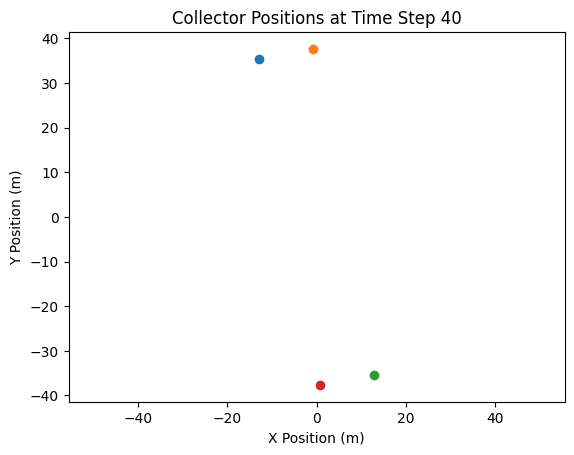

In [20]:
col_pos = phringe.get_collector_positions()  # At time step 0

col_pos_x = col_pos[0]
col_pos_y = col_pos[1]

# Plot all four collectors at time step 40
for i in range(4):
    plt.scatter(col_pos_x[i, 40], col_pos_y[i, 40], label=f'Collector {i + 1}')
plt.title('Collector Positions at Time Step 40')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.axis('equal')
plt.show()


